Build a toy shapes dataset. Strongly inspired from [this implementation](https://github.com/matterport/Mask_RCNN/blob/cbff80f3e3f653a9eeee43d0d383a0385aba546b/samples/shapes/shapes.py).

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm

import sys
sys.path.append("../../../")
import maskflow

import utils

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

params = maskflow.load_parameters("parameters.yml")
class_names = params["CLASS_NAMES"]

# Copy config next to data folder
maskflow.save_parameters(params, root_dir / "parameters.yml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate the dataset

In [3]:
height = params["IMAGE_MAX_DIM"]
width = params["IMAGE_MAX_DIM"]
count = 50
max_n_per_image = 10
training_size = 0.8

tfrecord_train_writer = tf.python_io.TFRecordWriter(str(data_dir / "training_data.tfrecord"))
tfrecord_evaluation_writer = tf.python_io.TFRecordWriter(str(data_dir / "evaluation_data.tfrecord"))

train_ids, _ = train_test_split(np.arange(0, count), train_size=training_size)

for i in tqdm.trange(count):
    # Generate image specification
    bg_color, shapes = utils.random_image(height, width, max_n_per_image, class_names)
    
    # Generate the image
    image = utils.generate_image(bg_color, height, width, shapes)
    
    # Generate the mask
    mask, class_ids = utils.generate_mask(bg_color, height, width, shapes, class_names)
    
    basename = f"toy_{i:04d}"
    
    tf_example = maskflow.create_tf_example(i, basename, image, mask, class_ids)
    
    # Save it in the training or the eval dataset?
    if i in train_ids:
        tfrecord_train_writer.write(tf_example.SerializeToString())
    else:
        tfrecord_evaluation_writer.write(tf_example.SerializeToString())

tfrecord_train_writer.close()
tfrecord_evaluation_writer.close()

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 50/50 [00:00<00:00, 99.33it/s]


## Visualize some images with annotations

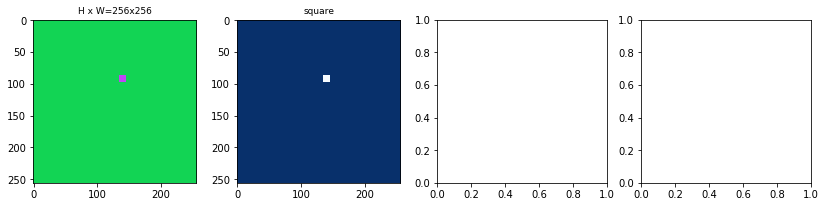

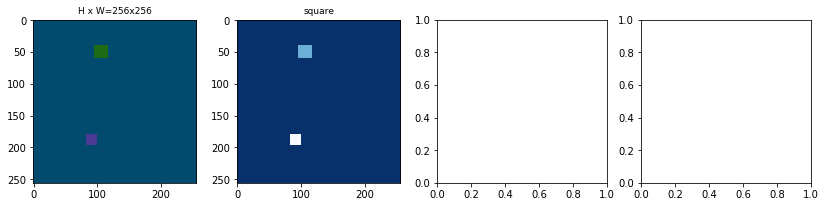

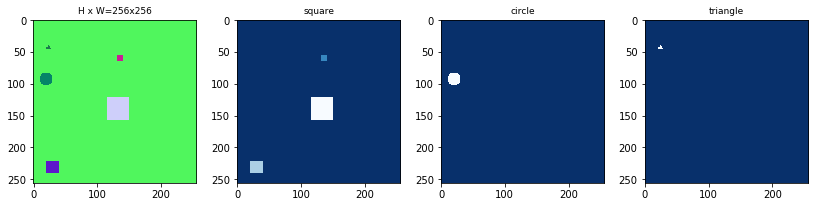

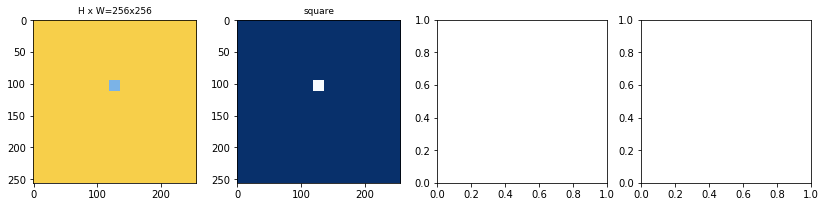

In [10]:
# Select the training dataset
tfrecord_path = data_dir / "training_data.tfrecord"

# Retrieve some data
images, annotations = maskflow.get_data(tfrecord_path, n=4, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"], class_names, limit=3)